### Juliana Afini - 67627

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
from scipy.stats import loguniform


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score,roc_auc_score, accuracy_score, r2_score, mean_squared_error, mean_absolute_error


from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
import shap


In [2]:
df = pd.read_csv("cleaned_income_evaluation.csv")

In [3]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31950,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
31951,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
31952,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
31953,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## 1. Modeling: XGBoost

### 1.1. Pipeline and model definition

#### 1.1.1. Prepare data

In [4]:

df['income'] = df['income'].apply(lambda x: 0 if x.strip() == "<=50K" else 1)

# split dataframe in features (X) and target variables (y)
X = df.drop(columns=['fnlwgt','education','income'], errors='ignore') # Drop any unnecessary columns (e.g., 'fnlwgt' as it's a weighting factor, not a feature)
y = df["income"]

#### 1.1.2. Pipeline construction

In [5]:
from category_encoders import TargetEncoder

cat_vars = ["occupation", "workclass", "marital_status", "race", "sex", "native_country", "relationship"]
num_vars = ["education_num", "capital_gain", "capital_loss", "hours_per_week"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="Missing")),
    #('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('encoder', TargetEncoder())
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars),
    ])


#### 1.1.3. Model definition

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

def define_model(cv, random_state):
    xgb_classifier = XGBClassifier(
        random_state=random_state, 
        objective="binary:logistic", 
        eval_metric="logloss",  # Classification loss function
    )

    params_xgb = {
        "max_depth": [3, 4, 5, 6, 10, 15],
        "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
        "subsample": np.arange(0.1, 1.0, 0.1),
        "colsample_bytree": np.arange(0.4, 1, 0.1),
        "colsample_bylevel": np.arange(0.4, 1, 0.1),
        "n_estimators": [100, 400, 500, 600, 1000],
    }

    xgb_random_search = RandomizedSearchCV(
        xgb_classifier, 
        param_distributions=params_xgb, 
        cv=cv, 
        random_state=random_state,
        scoring="accuracy",  
        n_iter=50,  # Set number of random search iterations
        n_jobs=-1  
    )

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  
        ('model', xgb_random_search)
    ])

    return model_pipeline

### 1.2. Model execution and hyperparameter tuning

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.model_selection import StratifiedKFold

model_xgb = define_model(cv=5, random_state=42)
model_xgb.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  [...
                                    n_iter=50, n_jobs=-1,
                                    param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                                         'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                                         'learning_rate': [0.005,
                                                                           0.01,
                                                                           0.05,
                                                                           0.1,
                                                                           0.2,
                                                                           0.3],
                                                         'max_depth': [3, 4, 5,
                                                                       6, 10,
                                                                       15],
                                                         'n_estimators': [100,
                                                                          400,
                                                                          500,
                                                                          600,
                                                                          1000],
                                                         'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                                    random_state=42, scoring='accuracy'))])

In [9]:
best_params = model_xgb.named_steps['model'].best_params_
best_params

{'subsample': 0.9,
 'n_estimators': 500,
 'max_depth': 4,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.5}

In [10]:
import pickle

with open("xgb_model.pkl", "wb") as file:
    pickle.dump(model_xgb, file)

with open("xgb_preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessor, file)

print(f"Best model saved")

Best model saved


In [11]:
import pickle

with open("xgb_model.pkl", "rb") as file:
    model_xgb = pickle.load(file)

with open("xgb_preprocessor.pkl", "rb") as file:
    preprocessor = pickle.load(file)

# Get predictions
y_pred = model_xgb.predict(X_test)
y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

### 1.3. Model validation

#### 1.3.1. Performance metrics

In [12]:
# Performance Metrics Analysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store metrics
accuracies = []
f1_scores = []
precisions = []
recalls = []
roc_aucs = []

# Compute metrics across all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    print(f"Processing fold {i+1}/5...")
    
    # Split data
    X_train_, X_test_ = X.iloc[train_index], X.iloc[test_index]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]
    
    # Train model
    # model_xgb = define_model(cv=5, random_state=42)
    model_xgb.fit(X_train_, y_train_)
    
    # Get predictions
    y_pred_ = model_xgb.predict(X_test_)
    y_pred_proba_ = model_xgb.predict_proba(X_test_)[:, 1]
    
    # Calculate metrics
    accuracies.append(accuracy_score(y_test_, y_pred_))
    f1_scores.append(f1_score(y_test_, y_pred_))
    precisions.append(precision_score(y_test_, y_pred_))
    recalls.append(recall_score(y_test_, y_pred_))
    roc_aucs.append(roc_auc_score(y_test_, y_pred_proba_))

# Calculate mean and std of metrics
metrics = {
    'Accuracy': (np.mean(accuracies), np.std(accuracies)),
    'F1 Score': (np.mean(f1_scores), np.std(f1_scores)),
    'Precision': (np.mean(precisions), np.std(precisions)),
    'Recall': (np.mean(recalls), np.std(recalls)),
    'ROC AUC': (np.mean(roc_aucs), np.std(roc_aucs))
}

# Print results
print("\nModel Performance Metrics:")
print("-" * 50)
for metric, (mean, std) in metrics.items():
    print(f"{metric}: {mean:.4f} (±{std:.4f})")


Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...



2 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Juafi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Juafi\anaconda3\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\Juafi\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1599, in fit
    self._Booster = train(
  File "C:\Users\Juafi\anaconda3\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\Juafi\anaconda3\lib\site-packages\xgboost\training

Processing fold 4/5...
Processing fold 5/5...

Model Performance Metrics:
--------------------------------------------------
Accuracy: 0.8680 (±0.0039)
F1 Score: 0.6984 (±0.0093)
Precision: 0.7762 (±0.0117)
Recall: 0.6349 (±0.0114)
ROC AUC: 0.9224 (±0.0039)


Observations:
- Strong overall accuracy (87%) → The model performs well in general, correctly classifying most instances, but accuracy alone may not fully reflect performance due to class imbalance.
- Balanced Precision (78%) vs. Recall (64%) → The model is more precise in predicting high-income individuals (>50K), but it misses some true positives (lower recall). This suggests a trade-off between precision and recall, meaning it prioritizes fewer false positives over false negatives.
- High ROC-AUC score (92%) → The model has strong discrimination ability, meaning it effectively separates high-income and low-income classes. This indicates good predictive power even with imbalanced classes.

#### 1.3.2. Performance visualizations

In [13]:
# Visualization of Model Performance
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['<=50K', '>50K'],
                yticklabels=['<=50K', '>50K'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_proba):
    """Plot precision-recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

def plot_learning_curves(estimator, X, y):
    """Plot learning curves"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training score',
             color='darkorange', lw=2)
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1,
                     color='darkorange')
    plt.plot(train_sizes, test_mean, label='Cross-validation score',
             color='navy', lw=2)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1,
                     color='navy')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Class distribution


Class Distribution in Test Set:


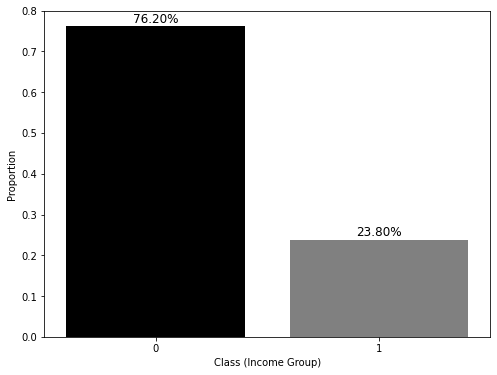

In [14]:
# Additional analysis: Class distribution
print("\nClass Distribution in Test Set:")

class_distribution = pd.Series(y_test).value_counts(normalize=True)

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette={'black', 'grey'})

plt.xlabel("Class (Income Group)")
plt.ylabel("Proportion")

# Show values on bars
for i, value in enumerate(class_distribution.values):
    plt.text(i, value + 0.01, f"{value:.2%}", ha='center', fontsize=12)

plt.show()

Confusion Matrix

Plotting Confusion Matrix...


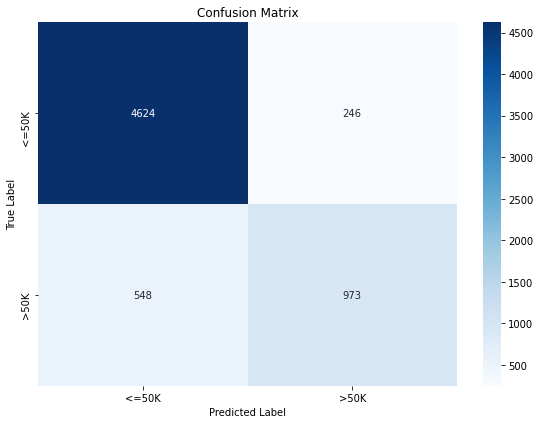


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4870
           1       0.80      0.64      0.71      1521

    accuracy                           0.88      6391
   macro avg       0.85      0.79      0.82      6391
weighted avg       0.87      0.88      0.87      6391



In [15]:
# Create all plots
print("Plotting Confusion Matrix...")
plot_confusion_matrix(y_test, y_pred)

# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Observations:
- Lower Recall for high-income class (>50K) → The model correctly identifies 65% of high-income earners (recall = 0.65), meaning 35% are misclassified as low-income. This suggests that the model might be favoring the majority class (≤50K), possibly due to class imbalance.
- Higher Precision for high-income predictions (0.77) → When the model predicts someone earns more than 50K, it is correct 77% of the time. This means it is cautious about predicting high-income individuals, but it still misses a fair number of them (as seen in the confusion matrix: 552 false negatives).

Curves


Plotting ROC Curve...


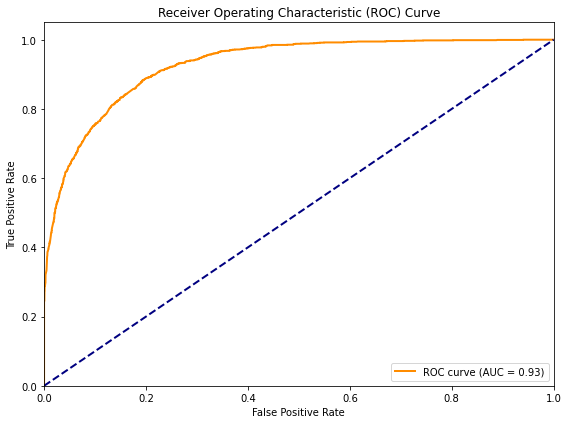


Plotting Precision-Recall Curve...


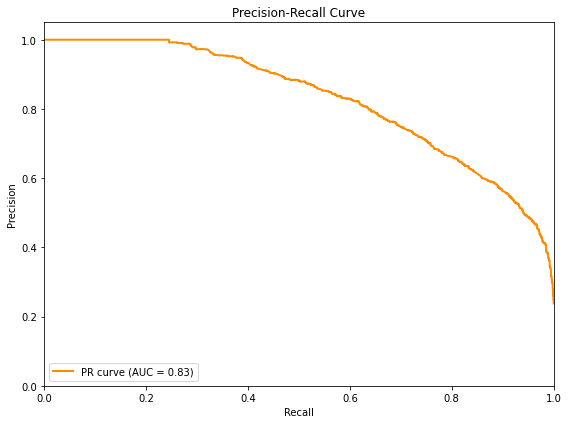

In [16]:
print("\nPlotting ROC Curve...")
plot_roc_curve(y_test, y_pred_proba)

print("\nPlotting Precision-Recall Curve...")
plot_precision_recall_curve(y_test, y_pred_proba)

Observations:
- Strong ROC-AUC ccore (0.92) → The ROC curve shows a high area under the curve (AUC = 0.92), indicating that the model effectively distinguishes between high-income (>50K) and low-income (≤50K) individuals. A score close to 1.0 suggests strong predictive power.
- Precision-Recall (PR) → The PR curve is lower than the ROC curve, which is expected due to class imbalance. The AUC = 0.82 suggests that the model maintains a good balance between precision and recall

## 1.4. Feature importance analysis

 99%|===================| 6349/6391 [00:54<00:00]        

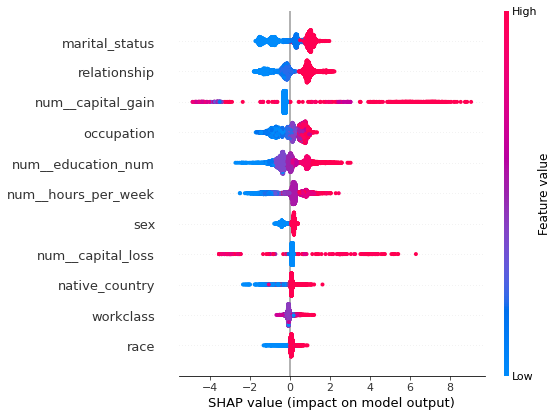

In [17]:
import shap
import numpy as np
import scipy.sparse

# Extract the best XGBoost model from RandomizedSearchCV
xgb_model_best = model_xgb.named_steps["model"].best_estimator_

# Ensure X_test is fully numeric and convert sparse matrix to dense
X_test_transformed = model_xgb.named_steps["preprocessor"].transform(X_test)
#X_test_transformed = X_test_transformed.toarray()  # Convert sparse matrix to dense

# Convert sparse matrix to dense only if necessary
if isinstance(X_test_transformed, scipy.sparse.spmatrix):
    X_test_transformed = X_test_transformed.toarray()
    
# Retrieve actual feature names after transformation
feature_names_transformed = model_xgb.named_steps["preprocessor"].get_feature_names_out()

# Convert X_test_transformed back to DataFrame with correct column names
import pandas as pd
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)

# Initialize SHAP Explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model_best, X_test_transformed)

# Compute SHAP values
shap_values_xgb = explainer_xgb(X_test_transformed)

feature_mapping = {
    "cat__0": cat_vars[0],  # First categorical variable (e.g., 'occupation')
    "cat__1": cat_vars[1],  # Second categorical variable (e.g., 'marital-status')
    "cat__2": cat_vars[2],  # Third categorical variable (e.g., 'workclass')
    "cat__3": cat_vars[3],  # ...
    "cat__4": cat_vars[4],
    "cat__5": cat_vars[5],
    "cat__6": cat_vars[6],
}

# Replace SHAP feature names with their real names
renamed_features = [feature_mapping.get(f, f) for f in feature_names_transformed]

# Generate SHAP Summary Plot with Correct Feature Names
shap.summary_plot(shap_values_xgb, X_test_transformed, feature_names=renamed_features)


Observations:
- Marital status has a strong impact on income predictions: Certain marital statuses significantly influence whether an individual earns more than 50K, likely due to dual-income households or financial stability advantages.
- Capital gains have the highest positive impact on income: Individuals with higher capital gains are much more likely to be in the >50K income group, reinforcing the role of investments in wealth accumulation.
- Occupation is an important determinant of income but interacts with other factors: Different job categories have varied impacts, but education and hours worked also play a role in determining earnings within occupations.
- More hours worked per week increases income, but the effect is not linear: While working more hours generally contributes to higher income, the effect plateaus at a certain point, indicating diminishing returns.
- Race, sex and native country have a lower overall impact compared to other variables: These features show some influence but are not as strong as financial or occupational factors, suggesting that systemic barriers may not be directly reflected in the dataset but could influence career progression.

#### Relationship between numerical variables

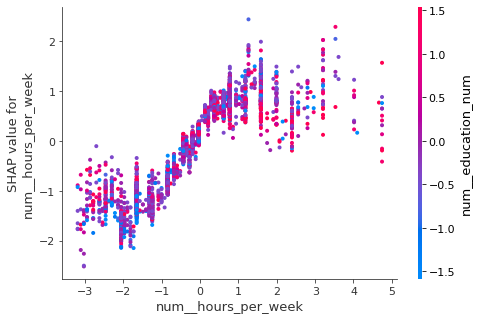

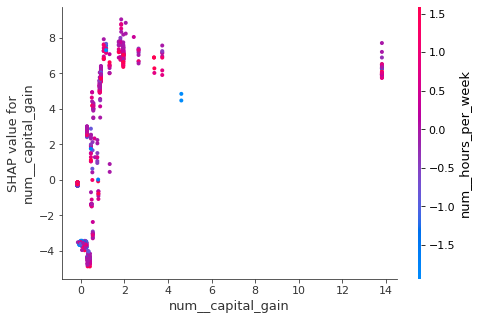

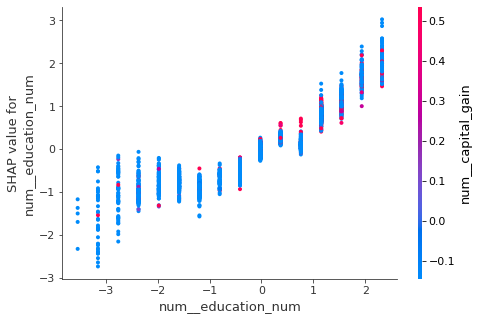

In [18]:
import shap
import numpy as np

# Ensure we get the correct transformed feature names
feature_names_transformed = model_xgb.named_steps["preprocessor"].get_feature_names_out()

# Convert SHAP values into the correct format
shap_values_fixed = shap_values_xgb.values if hasattr(shap_values_xgb, "values") else shap_values_xgb

# Generate SHAP Dependence Plot using Correct Feature Names
shap.dependence_plot(
    "num__hours_per_week",  # Directly use the feature name instead of index
    shap_values_fixed,
    X_test_transformed,
    interaction_index="num__education_num",  # Use feature name instead of index
    feature_names=feature_names_transformed  # Ensure proper labeling
)

shap.dependence_plot(
    "num__capital_gain", shap_values_fixed, X_test_transformed, interaction_index='num__hours_per_week', feature_names=renamed_features
)

shap.dependence_plot(
    "num__education_num", shap_values_fixed, X_test_transformed, interaction_index='num__capital_gain', feature_names=renamed_features
)


Observations:
- More hours worked per week leads to higher income, but with diminishing returns. The first plot shows a strong positive correlation between hours worked and SHAP values, meaning working more increases the likelihood of earning >50K. However, the effect plateaus after a certain number of hours, indicating diminishing returns on additional work hours.
- Capital gains have an exponential impact on income prediction. The second plot shows that small capital gains have little effect, but once past a certain threshold, the SHAP value jumps sharply. This suggests that investment income is a key differentiator between middle-class and high-income earners.
- Higher education levels strongly contribute to higher earnings.The third plot confirms that education has a linear impact on income predictions—as education increases, the SHAP values steadily rise. This suggests that formal education is a strong driver of high-income potential, but other factors (e.g., occupation) might still influence earnings within education levels.

#### Education analysis

In [19]:
if hasattr(shap_values_xgb, "values"):
    shap_values_xgb_array = shap_values_xgb.values  # Extract values if it's an Explanation object
else:
    shap_values_xgb_array = shap_values_xgb  # Already a NumPy array

# Verify feature names from the transformed dataset
feature_names_list = list(feature_names_transformed)

# Identify the correct education feature in the transformed dataset
education_feature_name = [col for col in feature_names_list if "education" in col]

if not education_feature_name:
    raise ValueError("Education feature not found in transformed feature names.")

# Get index of education feature in the transformed dataset
education_index = feature_names_list.index(education_feature_name[0])

X_test_original_education = X_test["education_num"].values  # Use the original education data

if isinstance(X_test_transformed, pd.DataFrame):
    X_test_transformed_array = X_test_transformed.to_numpy()
else:
    X_test_transformed_array = X_test_transformed

# Check consistency before constructing DataFrame
print("SHAP values shape:", shap_values_xgb_array.shape)
print("X_test_transformed shape:", X_test_transformed_array.shape)
print("Education feature index:", education_index)

# **Create DataFrame with original education values and SHAP values**
df_shap_edu = pd.DataFrame({
    "education_num": X_test_original_education,  # **Use original education values**
    "shap_value": shap_values_xgb_array[:, education_index],  # SHAP values for education
    "income_prediction": model_xgb.named_steps["model"].predict(X_test_transformed_array)  # Predictions
})

# Display first rows for validation
print(df_shap_edu.head())

SHAP values shape: (6391, 11)
X_test_transformed shape: (6391, 11)
Education feature index: 0
   education_num  shap_value  income_prediction
0             14    1.239976                  1
1             10    0.053268                  0
2             15    1.747158                  1
3             10    0.076601                  0
4             10    0.067496                  0


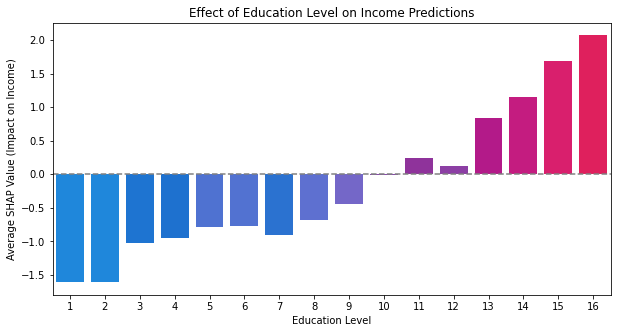

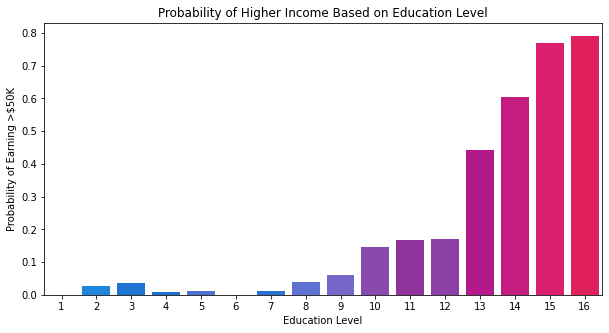

In [22]:
# **Analyze the impact of education on income**
education_analysis = df_shap_edu.groupby("education_num").agg(
    shap_avg=("shap_value", "mean"),  
    income_prob=("income_prediction", "mean")  
).reset_index()

cmap = shap.plots.colors.red_blue  
norm = plt.Normalize(education_analysis["shap_avg"].min(), education_analysis["shap_avg"].max())
colors = [cmap(norm(val)) for val in education_analysis["shap_avg"]]


# **Plot education level vs. SHAP impact on income**
plt.figure(figsize=(10, 5))
sns.barplot(data=education_analysis, x="education_num", y="shap_avg", palette=colors)
plt.axhline(y=0, linestyle="dashed", color="gray")
plt.xlabel("Education Level")
plt.ylabel("Average SHAP Value (Impact on Income)")
plt.title("Effect of Education Level on Income Predictions")
plt.show()

# **Plot probability of earning >$50K by education level**
plt.figure(figsize=(10, 5))
sns.barplot(data=education_analysis, x="education_num", y="income_prob", palette=colors)
plt.xlabel("Education Level")
plt.ylabel("Probability of Earning >$50K")
plt.title("Probability of Higher Income Based on Education Level")
plt.show()


In [23]:
df.groupby("education_num")["education"].value_counts()

education_num  education   
1              Preschool          49
2              1st-4th           161
3              5th-6th           317
4              7th-8th           626
5              9th               506
6              10th              921
7              11th             1167
8              12th              417
9              HS-grad         10362
10             Some-college     7178
11             Assoc-voc        1366
12             Assoc-acdm       1055
13             Bachelors        5208
14             Masters          1673
15             Prof-school       559
16             Doctorate         390
Name: education, dtype: int64

Observations: 
- Higher education levels (above 13) strongly correlate with higher SHAP values and increased probability of earning more than 50K, indicating that formal education plays a crucial role in income potential. The trend suggests a significant positive impact starting from college education (years 13-16).
- Lower education levels (1-8) have consistently negative SHAP values and near-zero probability of earning above 50K, highlighting the potential need for educational policies targeting early education accessibility and skill development programs to bridge income disparities.

## 1.5 Clustering to define policy scope

### 1.5.1. Effect of education level on income prediction (full dataset)

The feature selection is crucial for policy clustering because it helps us identify groups that might benefit the most from educational incentives. By analyzing SHAP values for education, we can determine which populations experience the highest returns on additional schooling and where disparities exist. Clustering these groups based on education level, occupation, sex, race, and native country allows us to uncover structural patterns, such as whether certain minorities, genders, or professions have lower access to higher education or do not receive proportional financial benefits from it.

From a policy perspective, this insight enables targeted interventions, such as scholarships for underrepresented groups, educational incentives for specific industries, or policies ensuring equal returns on education across demographics. Instead of applying broad policies that may not be effective for all populations, clustering helps tailor education-focused economic policies to the communities that need them the most, maximizing impact and efficiency.

In [24]:
import shap 

X_transformed = model_xgb.named_steps["preprocessor"].transform(X)

xgb_model_best = model_xgb.named_steps["model"].best_estimator_

explainer_xgb = shap.Explainer(xgb_model_best, X_transformed)

shap_values_xgb = explainer_xgb(X_transformed)

shap_values_xgb_array = shap_values_xgb.values if hasattr(shap_values_xgb, "values") else shap_values_xgb

feature_names_transformed = model_xgb.named_steps["preprocessor"].get_feature_names_out()

if not isinstance(X_transformed, pd.DataFrame):
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names_transformed)
else:
    X_transformed_df = X_transformed.copy()

feature_names_list = list(feature_names_transformed)

education_index = feature_names_list.index("num__education_num")
X_transformed_df["shap_education"] = shap_values_xgb_array[:, education_index]

feature_mapping = {
    "cat__0": cat_vars[0],  # First categorical variable (e.g., 'occupation')
    "cat__1": cat_vars[1],  # Second categorical variable (e.g., 'marital-status')
    "cat__2": cat_vars[2],  # Third categorical variable (e.g., 'workclass')
    "cat__3": cat_vars[3],  # ...
    "cat__4": cat_vars[4],
    "cat__5": cat_vars[5],
    "cat__6": cat_vars[6],
}

X_transformed_df = X_transformed_df.rename(columns=feature_mapping)

print(X_transformed_df.head())

df_analysis = X_transformed_df[['num__education_num','shap_education','occupation','native_country','race', 'sex']]

100%|===================| 31889/31955 [03:34<00:00]        

   num__education_num  num__capital_gain  num__capital_loss  \
0            1.149401           0.158241          -0.215172   
1            1.149401          -0.145174          -0.215172   
2           -0.413644          -0.145174          -0.215172   
3           -1.195167          -0.145174          -0.215172   
4            1.149401          -0.145174          -0.215172   

   num__hours_per_week  occupation  workclass  marital_status      race  \
0            -0.034227    0.133989   0.274975        0.045253  0.255393   
1            -2.221050    0.485276   0.285213        0.445962  0.255393   
2            -0.034227    0.059567   0.219390        0.104025  0.255393   
3            -0.034227    0.059567   0.219390        0.445962  0.125978   
4            -0.034227    0.452241   0.219390        0.445962  0.125978   

        sex  native_country  relationship  shap_education  
0  0.304870        0.245898      0.102493        0.707268  
1  0.304870        0.245898      0.447396        0

### 1.5.2. K-Means clustering

#### Define number of clusters

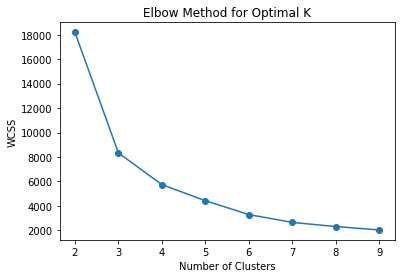

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_analysis)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

#### Plot clusters

In [26]:
# Function to plot clusters
def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    
    X_array = X.to_numpy()  

    sns.scatterplot(x=X_array[:, 0], y=X_array[:, 1], hue=labels, palette="viridis", legend="full")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


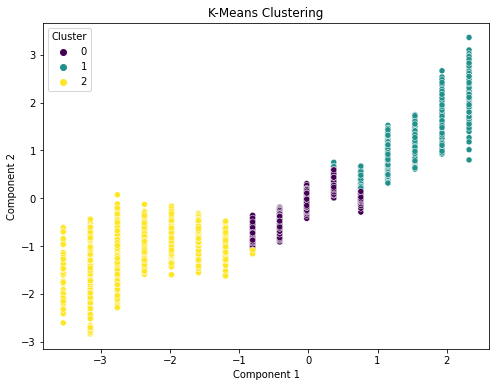

In [29]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# ## K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_analysis)
plot_clusters(df_analysis, kmeans_labels, "K-Means Clustering")
#kmeans_score = silhouette_score(df_analysis, kmeans_labels)
#print(f"K-Means Silhouette Score: {kmeans_score:.4f}")

In [33]:
kmeans_score = silhouette_score(df_analysis, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_score:.4f}")

K-Means Silhouette Score: 0.6391


#### Asign clusters to the dataset

In [30]:
# Asign clusters to the dataset

df["cluster"] = kmeans_labels

df["target_education"] = df["education_num"].apply(lambda x: "<13" if x < 13 else ">=13")

df.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,cluster,target_education
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1,>=13
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,1,>=13
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,0,<13
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,2,<13
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1,>=13


#### Evaluate clusters characteristics

In [31]:
cluster_counts = df["cluster"].value_counts(normalize=False).to_frame(name="Count")
cluster_counts["Percentage"] = (cluster_counts["Count"] / len(df) * 100).round(2)
print(cluster_counts)

   Count  Percentage
0  20185       63.17
1   8018       25.09
2   3752       11.74


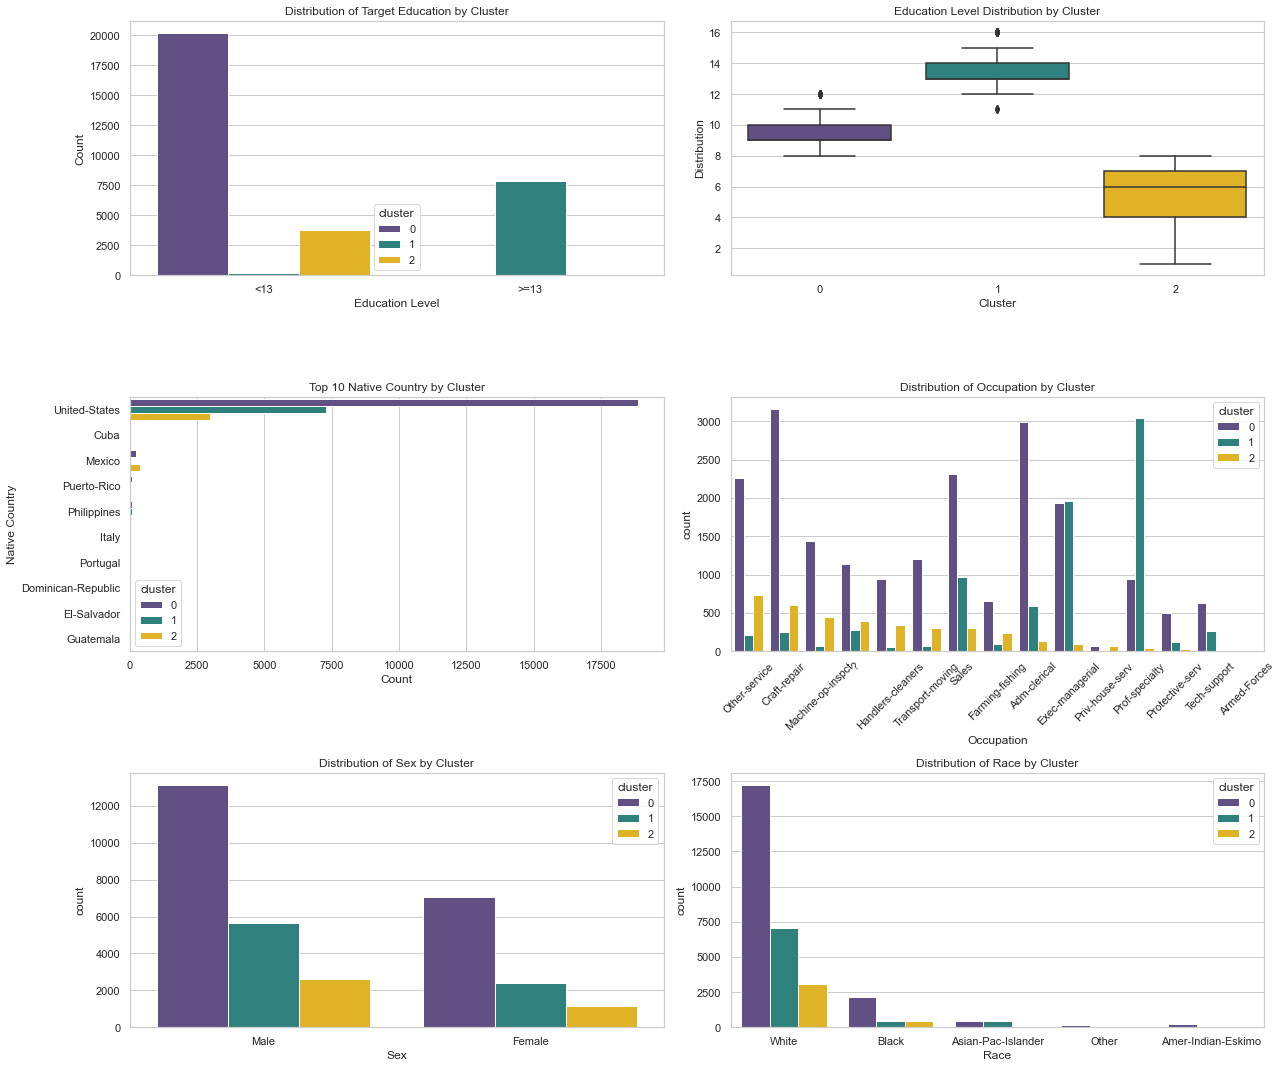

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define cluster colors based on previous scatter plot
cluster_palette = {0: "#5D478B", 1: "#218F8A", 2: "#FFC107"}  

sns.set(style="whitegrid")

# Define the columns for categorical distributions
categorical_columns = ["target_education", "native_country", "occupation", "race", "sex"]

fig, axes = plt.subplots(3, 2, figsize=(18, 15))  # Adjust layout for better fit
axes = axes.flatten()

order = df.groupby("target_education")["cluster"].value_counts().unstack().fillna(0)
order = order.sort_values(by=[2, 0], ascending=False).index  # Sort based on cluster 0 and then cluster 2

sns.countplot(data=df, x="target_education", hue="cluster", palette=cluster_palette, order=order, ax=axes[0])
axes[0].set_title(f"Distribution of Target Education by Cluster")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Education Level")

sns.boxplot(data=df, x="cluster", y="education_num", palette=cluster_palette, ax=axes[1])
axes[1].set_title("Education Level Distribution by Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Distribution")

order = df.groupby("native_country")["cluster"].value_counts().unstack().fillna(0)
order = order.sort_values(by=[2, 0], ascending=False).index  # Sort based on cluster 0 and then cluster 2

top_countries = order[:10]  # Select top 10 for native-country
sns.countplot(data=df[df["native_country"].isin(top_countries)], y="native_country", hue="cluster", palette=cluster_palette, ax=axes[2])
axes[2].set_title(f"Top 10 Native Country by Cluster")
axes[2].set_xlabel("Count")
axes[2].set_ylabel("Native Country")

order = df.groupby("occupation")["cluster"].value_counts().unstack().fillna(0)
order = order.sort_values(by=[2, 0], ascending=False).index  # Sort based on cluster 0 and then cluster 2

sns.countplot(data=df, x="occupation", hue="cluster", palette=cluster_palette, order=order, ax=axes[3])
axes[3].set_title(f"Distribution of Occupation by Cluster")
axes[3].set_xlabel("Occupation")
axes[3].tick_params(axis="x", rotation=45)  # Rotate labels for readability

order = df.groupby("sex")["cluster"].value_counts().unstack().fillna(0)
order = order.sort_values(by=[2, 0], ascending=False).index  # Sort based on cluster 0 and then cluster 2

sns.countplot(data=df, x="sex", hue="cluster", palette=cluster_palette, order=order, ax=axes[4])
axes[4].set_title(f"Distribution of Sex by Cluster")
axes[4].set_xlabel("Sex")

order = df.groupby("race")["cluster"].value_counts().unstack().fillna(0)
order = order.sort_values(by=[2, 0], ascending=False).index  # Sort based on cluster 0 and then cluster 2

sns.countplot(data=df, x="race", hue="cluster", palette=cluster_palette, order=order, ax=axes[5])
axes[5].set_title(f"Distribution of Race by Cluster")
axes[5].set_xlabel("Race")


plt.tight_layout()
plt.show()


#### Cluster 2: Extremely Low Education, Labor-Intensive Workforce (Policy Focus, Highest Priority)
- Demographics: More diverse in sex and race, with higher immigrant representation, including Mexico.
- Education Level: The lowest education level, with most individuals not even completing high school.
- Occupation: Similar to Cluster 0 but at a lower education level, leading to jobs in handlers-cleaners, lower-tier service positions, farming, and other unskilled labor roles.
- Policy Implications: Primary focus should be on basic education completion (e.g., GED programs, high school completion incentives, adult literacy initiatives). Additionally, accessible vocational training should be provided to create pathways into skilled labor roles.

#### Cluster 0: Low-Education, Predominantly Manual Labor Workforce (Policy Focus, Second Wave Priority)
- Demographics: Primarily white and male, but also has higher Black representation compared to other clusters. Some immigrant participation, mainly from Mexico.
- Education Level: Less than 13 years of education, meaning most individuals lack a college degree but have likely completed high school or are close to doing so.
- Occupation: Found in manual labor and service-oriented jobs, including craft repair, machine operation, transportation, administrative clerical roles, and sales.
- Policy Implications: Policies should focus on accessible upskilling opportunities —introduce tuition-free community college, vocational-to-degree bridge programs, and financial support for part-time studies.

#### Cluster 1: Highly Educated, Professional Workforce (Not Policy Focus)
- Demographics: The only cluster where the majority has ≥13 years of education, indicating a strong presence of college graduates and professionals.
- Education Level: Mostly bachelor’s degree or higher.
- Occupation: Concentrated in managerial, executive, and technical fields, requiring specialized education.
- Policy Implications: No direct policy focus, as this group already benefits from existing educational and career pathways.